In [1]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
#from skimage import io, color
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

In [2]:
img_path = 'fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

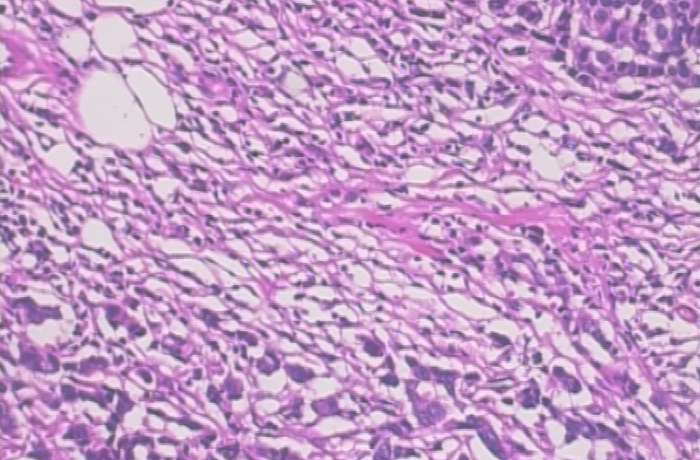

In [3]:
img

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#data_path = 'BreakHis/fold1_seperated_2_classes/train/40X'
training_dataset_path = 'fold1_seperated_2_classes/train/200X'
testing_dataset_path = 'fold1_seperated_2_classes/test/200X'

In [6]:
def train_transform():
  transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
      transforms.Normalize(mean = [0.7920, 0.6120, 0.7663], std = [0.1043, 0.1375, 0.0836])
    ])
  return transform

In [7]:
transform =  train_transform()

In [8]:
X = transform(img).unsqueeze_(0)

In [9]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [ ]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1269
    Root location: fold1_seperated_2_classes/train/200X
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.792, 0.612, 0.7663], std=[0.1043, 0.1375, 0.0836])
           )

In [ ]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 744
    Root location: fold1_seperated_2_classes/test/200X
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.792, 0.612, 0.7663], std=[0.1043, 0.1375, 0.0836])
           )

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 8,shuffle=True)

In [13]:
#Splitting Testing Data into 30% Validation and 70% Testing
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx) 
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 8,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=8, sampler=val_sampler)

In [14]:
from transformers import CvtConfig, CvtModel
from transformers import AutoImageProcessor, CvtForImageClassification
configuration = CvtConfig()
model = CvtForImageClassification(configuration)

c:\Users\Utkarsh Varman\torch3913\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model.to(device)

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
model(X.to(device))

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[0.3688, 0.2218]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None)

In [17]:
N_EPOCHS = 150
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9,weight_decay=0.03)
criterion = CrossEntropyLoss()

In [18]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [19]:
def save_checkpoint(model, epoch, optimizer, best_acc, train_losses, train_acc, val_losses, val_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'val_losses': val_losses,
        'val_acc': val_acc
    }
    torch.save(state, 'Models/cvt_200X.pth')

In [20]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): 
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) 

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt

def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    train_losses = []
    train_acc = []
    val_acc = []
    val_losses = []
    model = model.to(device)
    
    max_epoch_time = 0.0  # Initialize maximum epoch time
    
    for epoch in range(n_epochs):
        start_time = time.time()  # Start time for current epoch
        
        print("Epoch number: %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _, predicted = torch.max(outputs.logits, 1)

            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * running_correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f" % (
        running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc, test_dataset_loss = evaluate_model(model, test_loader, criterion)
        val_acc.append(test_dataset_acc)
        val_losses.append(test_dataset_loss)
        
        if test_dataset_acc > best_acc:
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc, train_losses, train_acc, val_losses, val_acc)

        end_time = time.time()  # End time for current epoch
        epoch_time = end_time - start_time
        
        max_epoch_time = max(max_epoch_time, epoch_time)  # Update maximum epoch time
        
        print("Time taken for epoch {}: {:.2f} seconds".format(epoch + 1, epoch_time))
        

    print('Finished Training')
    return model, train_losses, train_acc, val_acc, val_losses, max_epoch_time

# Train the model and get the maximum epoch time
model, train_losses, train_acc, val_acc, val_losses, max_epoch_time = train_nn(model, train_loader, val_loader, criterion, optimizer, 50)

Epoch number: 1
  -Training Dataset, Got 989 out of 1269 images correctly (77.935%). Epoch Loss: 0.486
-  Testing dataset. Got 189 out of 223 images correctly (84.753%). Loss: 0.366
Time taken for epoch 1: 39.26 seconds
Epoch number: 2
  -Training Dataset, Got 1040 out of 1269 images correctly (81.954%). Epoch Loss: 0.431
-  Testing dataset. Got 186 out of 223 images correctly (83.408%). Loss: 0.424
Time taken for epoch 2: 34.37 seconds
Epoch number: 3
  -Training Dataset, Got 1013 out of 1269 images correctly (79.827%). Epoch Loss: 0.430
-  Testing dataset. Got 191 out of 223 images correctly (85.650%). Loss: 0.376
Time taken for epoch 3: 34.61 seconds
Epoch number: 4
  -Training Dataset, Got 1041 out of 1269 images correctly (82.033%). Epoch Loss: 0.407
-  Testing dataset. Got 191 out of 223 images correctly (85.650%). Loss: 0.390
Time taken for epoch 4: 34.37 seconds
Epoch number: 5
  -Training Dataset, Got 1056 out of 1269 images correctly (83.215%). Epoch Loss: 0.392
-  Testing da

In [22]:
from ptflops import get_model_complexity_info

def get_flops(model, input_size):
    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)
    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")

input_size = (3,224,224)

# Compute FLOPS for the ViTForImageClassification model
get_flops(model, input_size)

CvtForImageClassification(
  19.61 M, 99.998% Params, 4.08 GMac, 99.780% MACs, 
  (cvt): CvtModel(
    19.61 M, 99.990% Params, 4.08 GMac, 99.780% MACs, 
    (encoder): CvtEncoder(
      19.61 M, 99.990% Params, 4.08 GMac, 99.780% MACs, 
      (stages): ModuleList(
        (0): CvtStage(
          61.7 k, 0.315% Params, 170.8 MMac, 4.178% MACs, 
          (embedding): CvtEmbeddings(
            9.6 k, 0.049% Params, 29.9 MMac, 0.732% MACs, 
            (convolution_embeddings): CvtConvEmbeddings(
              9.6 k, 0.049% Params, 29.9 MMac, 0.732% MACs, 
              (projection): Conv2d(9.47 k, 0.048% Params, 29.7 MMac, 0.727% MACs, 3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm(128, 0.001% Params, 200.7 KMac, 0.005% MACs, (64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.0, inplace=False)
          )
          (layers): Sequential(
            52.1 

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [24]:
total_params = count_parameters(model)
print(f"Total number of parameters in the integrated model: {total_params}")

Total number of parameters in the integrated model: 19613250


In [25]:
model_path = 'Models/cvt_200X.pth'
check = torch.load(model_path)

C:\Users\Utkarsh Varman\AppData\Local\Temp\ipykernel_35736\2084166956.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load(model_path)


In [26]:
check['best accuracy']

86.99551569506727

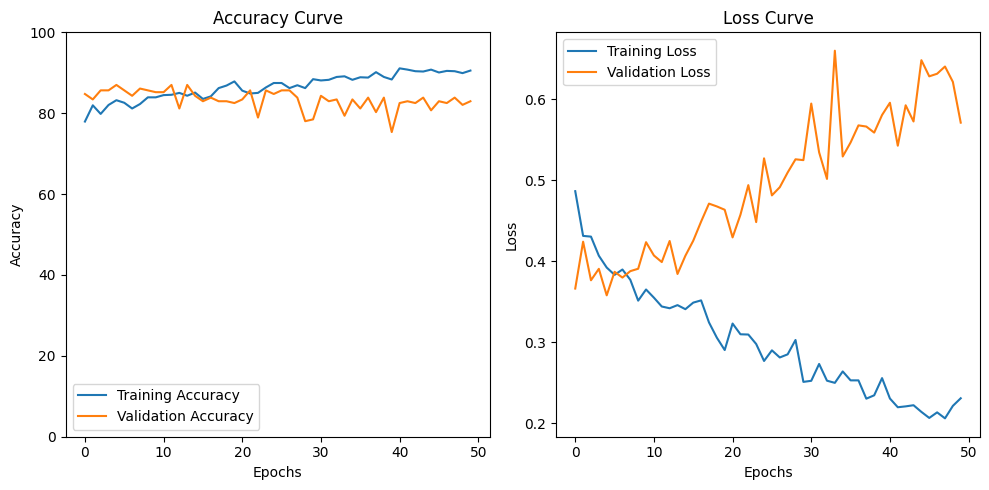

In [28]:
folder_path = 'Graphs/cvt_200X/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(figsize=(10, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100 for uniformity
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy_curve_cvt200X.png'))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss_curve_cvt200X.png'))

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'training_curves_cvt200X.png'))

plt.show()

In [29]:
model.load_state_dict(check['model'])

<All keys matched successfully>

In [30]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad():
          for data in tqdm(test_loader,desc='Evaluating'):
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss

In [31]:
evaluate_model(model,test_loader,criterion)    

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 66/66 [00:16<00:00,  4.05it/s]

-  Testing dataset. Got 439 out of 521 images correctly (84.261%). Loss: 0.372


(84.26103646833013, 0.3715745518830689)

In [32]:
def evaluate_model_classification_report(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.cpu().numpy())

            outputs = model(images)
            _, predicted = torch.max(outputs.logits, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels

In [33]:
true_labels, predicted_labels = evaluate_model_classification_report(model, test_loader)

In [34]:
from sklearn.metrics import classification_report,roc_auc_score
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72       185
           1       0.81      0.99      0.89       336

    accuracy                           0.84       521
   macro avg       0.89      0.78      0.81       521
weighted avg       0.86      0.84      0.83       521



In [35]:
auc_score = roc_auc_score(true_labels, predicted_labels)
print("AUC Score:", auc_score)

AUC Score: 0.7832368082368083


<b>Explainability</b>

In [36]:
img_path = 'fold1_seperated_2_classes/test/200X/Malignant/SOB_M_DC-14-2523-200-023.png'
img = Image.open(img_path)

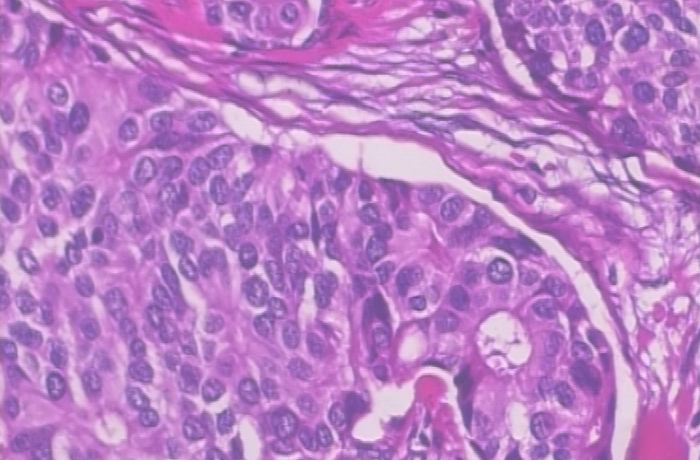

In [37]:
img

In [38]:
img = img.resize((224,224))

In [39]:
model.to(device)

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [40]:
img_tensor = transform(img)
X = transform(img).unsqueeze(0)
img_tensor.shape

torch.Size([3, 224, 224])

In [41]:
logits = model(X.to(device))

In [42]:
_,index = torch.max(logits.logits,dim=1)
classes = ['Benign','Malignant']
print(classes[index])

Malignant


In [43]:
model.eval()

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

C:\Users\Utkarsh Varman\AppData\Local\Temp\ipykernel_35736\2002878450.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load(model_path)


  Benign: 1.12%
  Malignant: 98.88%


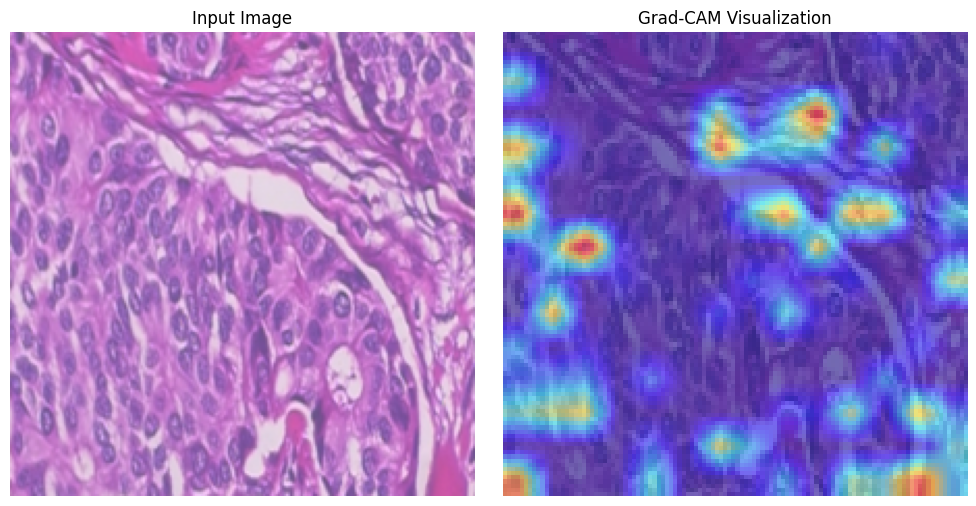

  Benign: 1.12%
  Malignant: 98.88%


(1, 98.88394474983215)

In [44]:
from transformers import CvtForImageClassification
from functools import partial
from typing import List, Callable, Optional
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]   
    
CATEGORY_NAMES = ["Benign", "Malignant"]

def category_name_to_index(model, category_name):
    return CATEGORY_NAMES.index(category_name)

def print_top_categories(model, img_tensor):
    logits = model(img_tensor.unsqueeze(0)).logits
    
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
    
    max_index = torch.argmax(probabilities).item()
    predicted_category = CATEGORY_NAMES[max_index]
    predicted_probability = probabilities[max_index].item() * 100  # Convert to percentage
 
    #print(f"Predicted Class: {predicted_category}")
    #print(f"Class Probabilities:")
    for idx, category in enumerate(CATEGORY_NAMES):
        print(f"  {category}: {probabilities[idx].item() * 100:.2f}%")
    
    return max_index, predicted_probability


def reshape_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), height, width, tensor.size(-1))
    norm = model.layernorm(tensor)
    return norm.transpose(2, 3).transpose(1, 2)

def reshape_gradcam_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), height, width, tensor.size(-1))
    return tensor.transpose(2, 3).transpose(1, 2)

#model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification(configuration)
model_path = 'Models/cvt_200X.pth'
check = torch.load(model_path)
model.load_state_dict(check['model'])
model.eval()
reshape_transform = partial(reshape_transform_cvt_huggingface, model=model,
                            width=img_tensor.shape[2] // 16, height=img_tensor.shape[1] // 16)
reshape_transform_gradcam = partial(reshape_gradcam_transform_cvt_huggingface, model=model,
                                     width=img_tensor.shape[2] // 16, height=img_tensor.shape[1] // 16)

targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Malignant")),
                       ClassifierOutputTarget(category_name_to_index(model, "Benign"))]

target_layer_dff = model.cvt.encoder.stages[-1].layers[-1]
target_layer_gradcam = model.cvt.encoder.stages[-1].layers[-2]

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.Tensor=img_tensor,
                          input_image: Image=img,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:
        
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        batch_results = cam(input_tensor=repeated_tensor, targets=targets_for_gradcam)
        
        results = []
        for i, grayscale_cam in enumerate(batch_results):
            category_name = "Benign" if i == 0 else "Malignant"
            visualization = show_cam_on_image(np.float32(input_image) / 255, grayscale_cam, use_rgb=True)
            visualization = cv2.resize(visualization, (visualization.shape[1] // 2, visualization.shape[0] // 2))
            
            results.append(visualization)
        return np.hstack(results)


top_category_index, top_probability = print_top_categories(model, img_tensor)

target_for_gradcam = ClassifierOutputTarget(top_category_index)

grad_cam_result = run_grad_cam_on_image(
    model=model,
    target_layer=target_layer_gradcam,
    targets_for_gradcam=[target_for_gradcam],
    reshape_transform=reshape_transform_gradcam
)
def plot_images(input_image: np.ndarray, gradcam_image: np.ndarray):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the original input image
    ax[0].imshow(input_image.astype(np.uint8))  # Ensure input_image is in uint8 format
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    # Plot the Grad-CAM visualization
    ax[1].imshow(gradcam_image)
    ax[1].set_title("Grad-CAM Visualization")
    ax[1].axis("off")
    
    plt.tight_layout()
    plt.show()


input_image_np = np.array(img) 
plot_images(input_image_np, grad_cam_result)

print_top_categories(model, img_tensor)

